http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

http://www.ipeadata.gov.br/

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [125]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

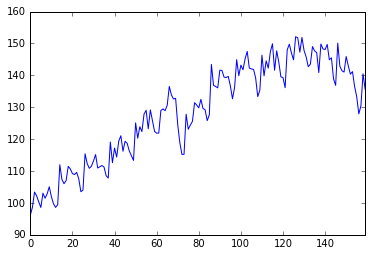

In [126]:
dataset = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataset.columns = ['DATA','IBC_BR']
dataset['IBC_BR'].plot()

In [127]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

In [128]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [129]:
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataframe.columns = ['DATA','IBC_BR']
dataset = dataframe['IBC_BR'].values.reshape(-1, 1)
dataset = dataset.astype('float32')

In [130]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [131]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(107, 53)


In [132]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [148]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [149]:
#trainY

In [150]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [158]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.2615
Epoch 2/100
0s - loss: 0.1342
Epoch 3/100
0s - loss: 0.0779
Epoch 4/100
0s - loss: 0.0523
Epoch 5/100
0s - loss: 0.0378
Epoch 6/100
0s - loss: 0.0354
Epoch 7/100
0s - loss: 0.0345
Epoch 8/100
0s - loss: 0.0329
Epoch 9/100
0s - loss: 0.0284
Epoch 10/100
0s - loss: 0.0315
Epoch 11/100
0s - loss: 0.0312
Epoch 12/100
0s - loss: 0.0233
Epoch 13/100
0s - loss: 0.0226
Epoch 14/100
0s - loss: 0.0154
Epoch 15/100
0s - loss: 0.0192
Epoch 16/100
0s - loss: 0.0162
Epoch 17/100
0s - loss: 0.0208
Epoch 18/100
0s - loss: 0.0215
Epoch 19/100
0s - loss: 0.0179
Epoch 20/100
0s - loss: 0.0171
Epoch 21/100
0s - loss: 0.0123
Epoch 22/100
0s - loss: 0.0130
Epoch 23/100
0s - loss: 0.0161
Epoch 24/100
0s - loss: 0.0145
Epoch 25/100
0s - loss: 0.0157
Epoch 26/100
0s - loss: 0.0143
Epoch 27/100
0s - loss: 0.0104
Epoch 28/100
0s - loss: 0.0130
Epoch 29/100
0s - loss: 0.0145
Epoch 30/100
0s - loss: 0.0128
Epoch 31/100
0s - loss: 0.0148
Epoch 32/100
0s - loss: 0.0137
Epoch 33/100
0s -

KeyError: 'val_loss'

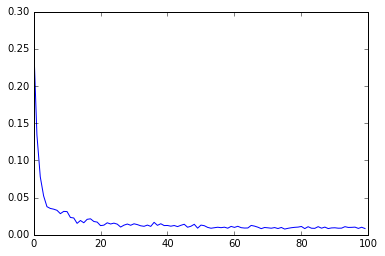

In [159]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [160]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 100.50 RMSE
Test Score: 101.13 RMSE


In [161]:
print r2_score(trainY,model.predict(trainX)), r2_score(testY,model.predict(testX))

0.888758373432 0.144834848895


In [162]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

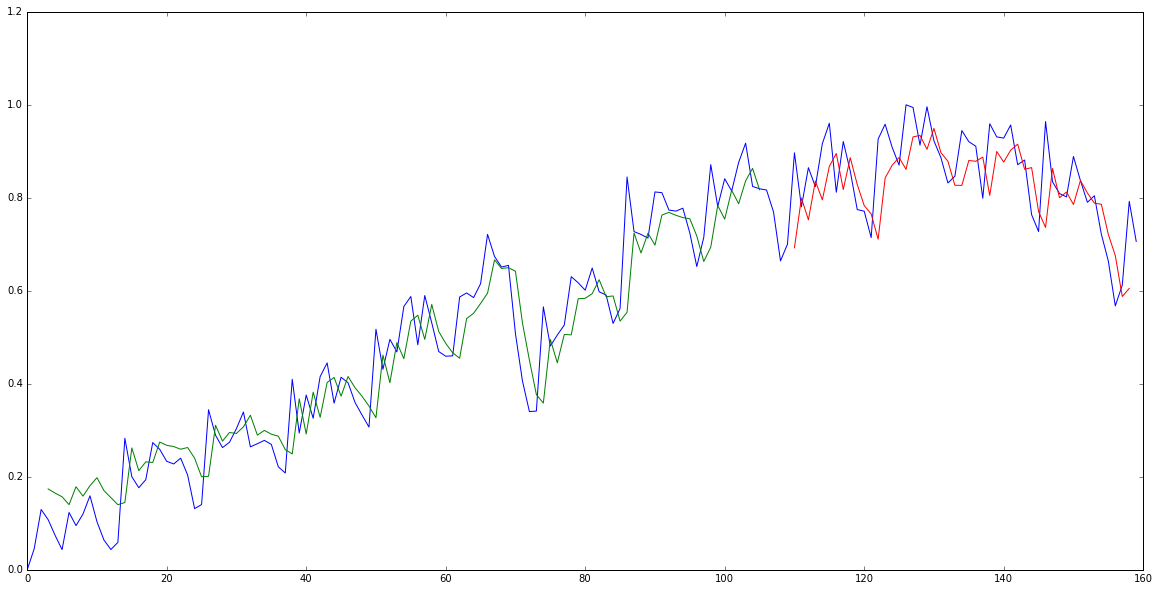

In [163]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)